## Gaussian Splatting

In [17]:
import os
import scipy.signal as sp
%matplotlib inline
import sys  
import importlib

sys.path.append('../Libraries') # adjust as needed

# load the local library
import sdc_config3 as sdc
import gaussplat as gp

# array compute and plotting
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import imageio
from PIL import Image
import io

# for gaussian functions and plotting
from mpl_toolkits.mplot3d import Axes3D
from torch.distributions.multivariate_normal import MultivariateNormal

### Forward model parameters
Filter mask, PSF

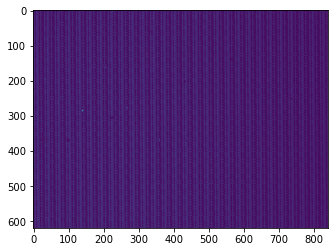

Shape of the filter array: torch.Size([620, 840, 45])


In [2]:
# Filter mask

# Load filter calibration data
data_folder = '../Calibration_Data'
file_name = 'filterCal_every2nm_darksub_2021-02-03.mat'

# Import the filter stack from the specified file
wavelengths, ci, filter_stack = sdc.importFilterStack(data_folder, file_name)

# Adjust CI values for zero-based indexing
# Define the cropped part of the image
ci_adjusted = [ci[0] - 1, ci[1] - 1, ci[2], ci[3]]

# Define wavelength sampling parameters
wavelength_min = 450
wavelength_max = 800
wavelength_step = 8

# Create a new array of wavelengths
wavelength_new = np.arange(wavelength_min, wavelength_max + wavelength_step, wavelength_step)

# Sum the filter array over the specified wavelength range
filt_arr = sdc.sumFilterArray(filter_stack, wavelengths, wavelength_min, wavelength_max, wavelength_step)
filt_arr = filt_arr / np.amax(filt_arr) # normalize
m = torch.tensor(filt_arr) # make tensor

# Plot the sum of the filter array across the last dimension
plt.figure()
plt.imshow(torch.sum(m, axis=2))
plt.show()

# Print the shape of the tensor
print("Shape of the filter array:", m.shape)

# Extract dimensions for further processing
# NL is the number of wavelengths
NY, NX, NL = m.shape

torch.Size([620, 840])


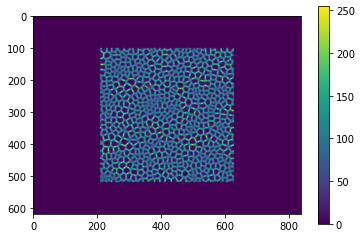

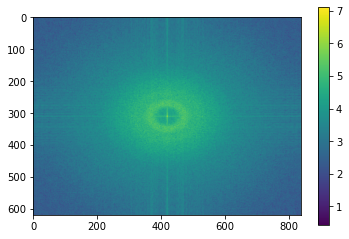

In [3]:
# PSF

datafolder = '../PSF'
fname = 'psf_090_1.png'
psf = torch.from_numpy(imageio.imread(os.path.join(datafolder, fname)))

 # Expand the PSF to match the shape of the filter array
pad_h = (m.shape[0] - psf.shape[0]) // 2
pad_w = (m.shape[1] - psf.shape[1]) // 2
padding = (pad_w, m.shape[1] - psf.shape[1] - pad_w, pad_h, m.shape[0] - psf.shape[0] - pad_h)
h = torch.nn.functional.pad(psf, padding, mode='constant', value=0)
print(h.shape)

plt.figure()
plt.imshow(h)
plt.colorbar()
plt.show()

hf = torch.fft.fftshift(torch.fft.fft2(h,dim=(0,1)))
plt.imshow(torch.log10(torch.abs(hf)))
plt.colorbar()
plt.show()

### Get ground truth measurement
Using Cal Marbles simulated data

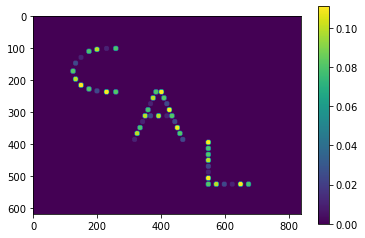

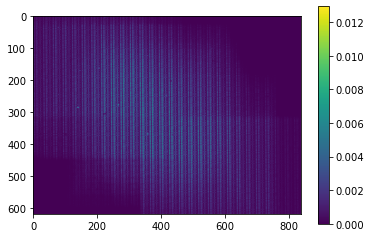

In [6]:
# load some measurements

datafolder = '../Sample_Objects/'
fname = 'cal_marbles.npy' # cal_beads_numpy_array
cal_beads = torch.from_numpy(np.load(os.path.join(datafolder, fname)))
cal_beads_padded = sdc.pad(cal_beads)
plt.figure()
plt.imshow(cal_beads[:,:,0])
plt.colorbar()
plt.show()

# Pad PSF
h_padded = sdc.pad(h) # double the size of h
h_padded_3d = sdc.make3d(h_padded, NL) # copy h NL times along the 3rd dimension
hf_padded_3d = sdc.fft3d(h_padded_3d) # take fft along dim 0 and 1

gt_measurement = sdc.forwardmodel3d(cal_beads_padded, hf_padded_3d, m)
gt_measurement = gt_measurement/torch.norm(gt_measurement) # normalize
plt.figure()
plt.imshow(gt_measurement)
plt.colorbar()
plt.show()

### Initialize guess with random gaussians

In [21]:
importlib.reload(gp)

<module 'gaussplat' from '../Libraries/gaussplat.py'>

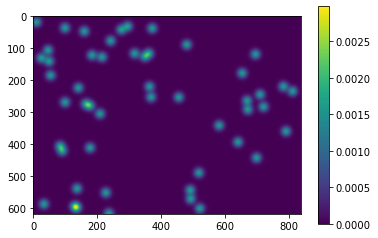

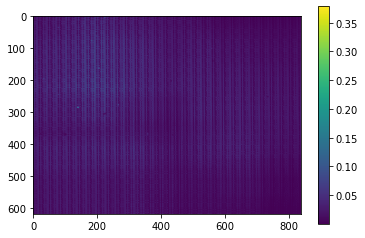

In [22]:
# initialize the gaussians

K = 50  # number of beads

muxs_init = torch.rand(K, 1) * NX - NX/2
muys_init = torch.rand(K, 1) * NY - NY/2
muls_init = torch.rand(K,1) * NL - NL/2
sigxs_init = 10.
sigys_init = 10.
sigls_init = 5.
lr_init = 10.
[x,y,coordinates] = gp.createMeshGrid(NX, NY)

# randomize the mean position; create a torch vector of [50,2] uniform sampled
g_init_beads = [] # empty list of gauss objects
g_init_obj = torch.zeros_like(h)
g_init_meas = torch.zeros_like(h)

# go through beads
for k in np.arange(K):
    # get bead objects
    g_init_beads.append(gp.GaussObject(muys_init[k], muxs_init[k], muls_init[k], sigys_init, sigxs_init, sigls_init, learningrate=lr_init))
    # get 2D pixel values of bead objects
    g_init_obj = g_init_obj + g_init_beads[k].computeValues(coordinates, NY, NX)
    # get measurement of bead objects
    g_init_meas = g_init_meas + gp.forwardSingleGauss(g_init_beads[k], NX, NY, NL, h, m)

plt.figure()
plt.imshow(g_init_obj.detach().numpy())
plt.colorbar()
plt.figure()
plt.imshow(g_init_meas.detach().numpy())
plt.colorbar()

### Gradient descent

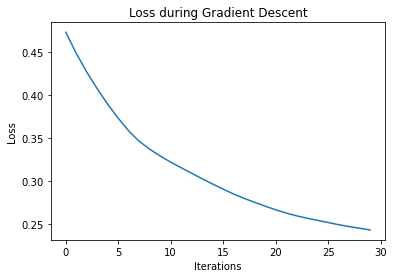

In [25]:
# Set number of iterations and initialize the loss tracker
# Need to rerun initialize random gaussian guess cells every time **
max_iters = 30
thresh = 1e-4
loss_GD = []
frames = []

# Define figure size and DPI for consistent frame sizes
figsize = (12, 8)
dpi = 100
#colorbar ranges
vmin = -0.01
vmax = 0.01

# Optimization loop
for i in range(max_iters):
    computed_measurement = torch.zeros_like(h)
    computed_vals = torch.zeros_like(h)
    for k in range(K):
        computed_vals = computed_vals + g_init_beads[k].computeValues(coordinates, NY, NX)
        # get measurement of bead objects
        computed_measurement = computed_measurement + gp.forwardSingleGauss(g_init_beads[k], NX, NY, NL, h, m)

    computed_measurement = computed_measurement / torch.norm(computed_measurement) # normalize
    
    # Grab a frame every 5 iterations
    if i % 1 == 0:
        fig = plt.figure(figsize=figsize, dpi=dpi)
        plt.subplot(1, 3, 1)
        plt.imshow(computed_vals.detach().cpu().numpy(), cmap='jet')
        plt.title("Beads Guess")
        plt.xticks([])  # Remove x ticks
        plt.yticks([])  # Remove y ticks

        plt.subplot(1, 3, 2)
        plt.imshow(computed_measurement.detach().cpu().numpy(), cmap='jet')
        plt.title("Beads Guess Measurement")
        plt.xticks([])  # Remove x ticks
        plt.yticks([])  # Remove y ticks

        plt.subplot(1, 3, 3)
        im = plt.imshow((computed_measurement - gt_measurement).detach().cpu().numpy(), cmap='jet', vmin=vmin, vmax=vmax)
        plt.title("Measurement Error")
        plt.xticks([])  # Remove x ticks
        plt.yticks([])  # Remove y ticks
        cbar = plt.colorbar(im, fraction=0.035, pad=0.04)  # Adjust the colorbar size
        cbar.set_label('Error')  # Label the colorbar
        cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        cbar.ax.yaxis.get_major_formatter().set_powerlimits((0,0))  # Adjust the limits for scientific notation
        
        frames.append(fig)  # Append the figure to the frames list
        plt.close(fig)

    
    # Compute loss (difference between computed measurement and true measurement)
    loss = torch.norm(computed_measurement - gt_measurement)
    
    # Store loss, parameters of guess, and check for learning
    loss_GD.append(loss.item())
    if i > 0: # stop if loss isn't changing
        if np.abs(loss_GD[i] - loss_GD[i-1]) < thresh:
            break
    
    # Perform a gradient step to update Gaussian parameters
    loss.backward()
    
    # Take step and reset gradients
    for k in range(K):
        g_init_beads[k].gradStep()
        g_init_beads[k].zeroGrad()

# Plot the loss over iterations
plt.figure()
plt.plot(loss_GD)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss during Gradient Descent')
plt.show()

In [26]:
frames_images = []
# Set duration for the first and last frames
first_frame_duration = 500  # 500 ms for the first frame
last_frame_duration = 500   # 500 ms for the last frame
normal_frame_duration = 100  # 100 ms for the other frames

for fig in frames:
    # Convert the figure to an image
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')  # Save figure to a buffer
    buf.seek(0)
    frame_image = Image.open(buf)
    
    if frame_image.mode != 'RGB':
        frame_image = frame_image.convert('RGB')
    
    frames_images.append(frame_image)
    buf.close()

# List of durations for each frame
durations = [first_frame_duration] + [normal_frame_duration] * (len(frames_images) - 2) + [last_frame_duration]

# Save the GIF with custom frame durations
frames_images[0].save(
    "cal_beads_gd.gif", 
    save_all=True, 
    append_images=frames_images[1:], 
    duration=durations, 
    loop=0
)